# **SW09: Clustering**

This notebook demonstrates clustering using k-means and DBSCAN. Furthermore, we explore the elbow method to find the optimal number of clusters (for k-means) and evaluate the clustering results using the silhouette score.

In addition to this notebook, you should take a look at the following interesting [web resource on clustering](https://educlust.dbvis.de/#).

---

## **Setup**



In [2]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Some Jupyter magic for nicer output
%config InlineBackend.figure_formats = ["svg"]   # Enable vectorized graphics

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

# Adjust the default settings for plots
import sys
sys.path.append("..")
import ml
ml.setup_plotting()

## **Data preparation**

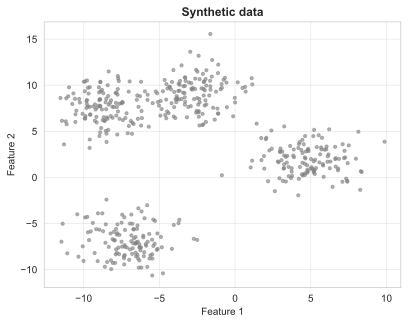

In [3]:
# The make_blobs function generates random data points around a specified 
# number of centers. We will use this function to generate a dataset with
# 500 data points and 4 centers.
X, _ = make_blobs(n_samples=500, centers=4, cluster_std=1.7, random_state=42)
data = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])

# Plot the data
plt.scatter(data["Feature 1"], data["Feature 2"], 
            color="gray", s=10, alpha=0.6, edgecolor="gray")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic data", fontweight="bold")
plt.show()

### **Data normalization**

Normalization ensures that all features contribute equally to the clustering 
process by scaling them to a similar range. This is crucial in distance-based 
algorithms like k-means, where differences in feature scales can distort the 
clustering results. Here, we will use the 
[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) 
from scikit-learn to normalize the data.

In [4]:
X = StandardScaler().fit_transform(X)

---

## **k-means clustering**

k-means clustering is a popular unsupervised machine learning algorithm used to partition a dataset into distinct groups or clusters. The algorithm aims to minimize the variance within each cluster and maximize the variance between different clusters. It achieves this by iteratively assigning data points to clusters based on their proximity to the cluster centroids and then updating the centroids to be the mean of the data points assigned to them.

Running k-means clustering on the data is generally straightforward:

c:\Daten\ADLS\ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Daten\ADLS\ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


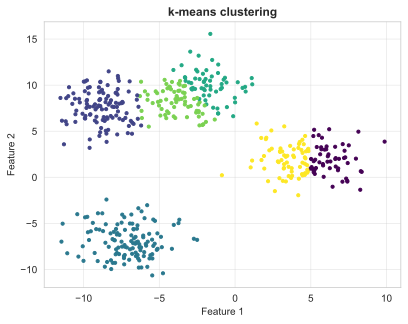

In [5]:
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X)

# Visualize the clusters
plt.scatter(data["Feature 1"], data["Feature 2"], 
            c=labels, s=10, cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("k-means clustering", fontweight="bold")
plt.show()

### **Inertia**

The intertia (also known as the *within-cluster sum of squares* (WCSS)) measures
the sum of squared distances of samples to their closest cluster center. 
If $\mu_j$ is the center of cluster $C_j$, and $\min_{\mu_j \in C}(||x_i - \mu_j||^2)$
is the distance of the data point $x_i$ to its closest cluster center, then the inertia is given by:

$$\sum_{i=0}^{n} \min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

The inertia is a measure of how well the data points are clustered.
The lower, the better the clustering. scikit-learn provides the inertia as 
an attribute of the KMeans object: `kmeans.inertia_`. 

In [6]:
########################
###    EXERCISE 1    ###
########################

# Compute the inertia for the k-means model using only Python/NumPy only.
# 
# Hint: The kmeans.labels_ attribute contains the cluster assignments for each
#       data point. The kmeans.cluster_centers_ attribute contains the cluster
#       centers. 

In [7]:

# 1. Get the cluster centers
centers = kmeans.cluster_centers_
# 2. Get the labels of the data points
labels = kmeans.labels_
# 3. Compute the distance of each data point to its cluster center
distances = np.sum((X - centers[labels])**2, axis=1)
# 4. Compute the inertia
inertia = np.sum(distances)
print("Own impelmentation:     %.3f" % inertia)
print("sklearn implementation: %.3f" % kmeans.inertia_)

Own impelmentation:     60.558
sklearn implementation: 60.558


### **The elbow method**

The parameter $k$ is not known in advance, so we need to find a way to determine
the optimal number of clusters. One (heuristic) way to do this is to use the elbow method.
It consists of plotting the inertia as a function of the number
of clusters and looking for the "elbow" point, where the inertia starts to
decrease more slowly. This point is usually a good choice for the number of
clusters. Let's verify this for our synthetic dataset.

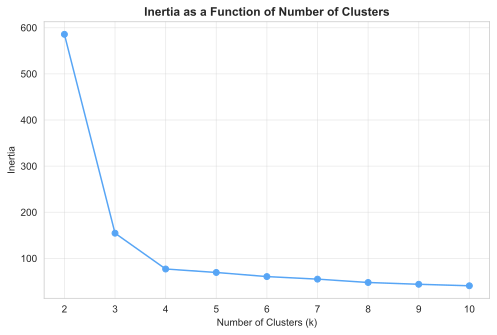

In [9]:
########################
###    EXERCISE 2    ###
########################

# Compute k-means clustering for k=2 to k=10 and plot the inertia as a function
# of the number of clusters. What can you observe?


# Liste zum Speichern der Inertia-Werte
inertia_values = []

# Berechnen der  K-Means für k = 2 bis k = 10
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # fittet das Model
    inertia_values.append(kmeans.inertia_)  # Speichert die Inertia

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Inertia as a Function of Number of Clusters")
plt.grid(True)
plt.show()

**The elbow point is at 4k and the diffrence between 2k and 3k is huge. So they are better grouped at 3k. If the clusters getting higher then 4 there isn't a big difference in the output. So the trade off overall is 4.**

### **Silhouette score**

While the inertia (sum of squared distances to the nearest cluster center) is a
useful metric for evaluating the quality of a clustering, it has some shortcomings:
- It is not normalized and depends on the number of data points. It is therefore not directly
  comparable across datasets.
- Noise and outliers can have a large impact on the inertia, which can be problematic
- It assumes that clusters are spherical and equally sized, which is not always the case. 


The silhouette score is a metric that addresses some of these shortcomings. It measures
how similar a sample $i$ is to its own cluster compared to other clusters. It is defined as:
$$ s_i = \frac{b_i - a_i}{\max(a_i, b_i)} $$
 where $a_i$ is the average distance of sample $i$ to all other points in the same cluster, and
$b_i$ is the average distance of sample $i$ to all points in the nearest cluster. The total silhouette
score is then the average of $s_i$ over all samples.

The score ranges from -1 to 1, where a high value indicates that the sample is well matched to
its own cluster and poorly matched to neighboring clusters. A negative value indicates that
the sample might be assigned to the wrong cluster.

The silhouette score can be easily computed using the [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) function from sklearn.metrics.

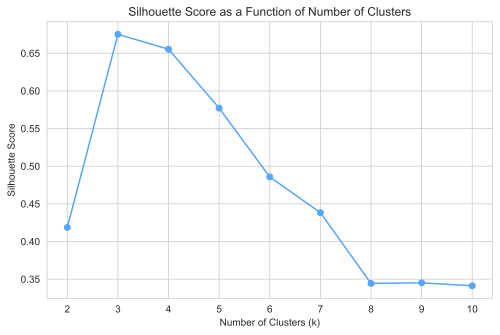

In [ ]:
########################
###    EXERCISE 3    ###
########################

# Compute the silhouette score for k=2 to k=10 and plot the silhouette score as a function
# of the number of clusters. What can you observe?

# Liste zum Speichern der Silhouette Scores
silhouette_scores = []

# Berechnung des K-Means und Silhouette Score für k = 2 bis k = 10
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)  # Clusterzuweisungen
    score = silhouette_score(X, labels)  # Berechnung des Silhouette Scores
    silhouette_scores.append(score) #Die Werte der Liste hinzufügen

# Plot der Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score as a Function of Number of Clusters")
plt.grid(True)
plt.show()


#The silhouette score reaches its highest point at k=3 (indicating the best clustering configuration) and declines steadily until k = 8.
#Beyond 𝑘=8, there is no significant improvement in the silhouette score, regardless of adding more clusters.


In [ ]:

# Discussion:
# - The silhouette score is highest for k=3, which is lower than the expected
#   and correct number of clusters (k=4). This is because two out of the four
#   clusters are very close to each other, which makes it difficult for the
#   silhouette score to distinguish between them. 
# - Nevertheless, the silhouette score is more robust than the inertia, as 
#   discussed above.

## **DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups points based on their density, identifying clusters of arbitrary shapes and labeling low-density points as noise. It does not require pre-specifying the number of clusters and is robust to outliers.

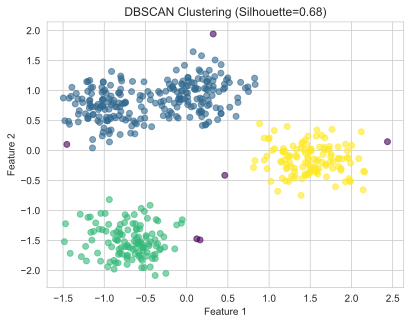

In [8]:
dbscan = DBSCAN(eps=0.3, min_samples=3)
labels = dbscan.fit_predict(X)
dbscan_silhouette = silhouette_score(X[labels != -1], labels[labels != -1])

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.6)
plt.title(f"DBSCAN Clustering (Silhouette={dbscan_silhouette:.2f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

**Discussion**:
- DBSCAN is not able to detect the correct number of clusters, even though the
  silhouette score is quite high. This is because DBSCAN is not able to detect
  the correct number of clusters in this dataset.
- DBSCAN is more suitable for datasets with varying cluster densities and shpaes, where
  the clusters are not necessarily spherical.
- In this case, k-means is the better choice, as the clusters are spherical and well-separated.
